<a href="https://colab.research.google.com/github/AnastasiiaVladimirovna/transcriptomics_homeworks/blob/main/hw9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Кусочек из семинара
Загрузим все необходимое и подговоим наши данные

In [ ]:
!pip3 install scanpy[leiden] anndata2ri scikit-misc scvi-tools opentsne

import os
os.kill(os.getpid(), 9)
     

In [ ]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd

sc.settings.verbosity = 3
sc.set_figure_params(dpi=150)
sns.set_style("ticks")

In [ ]:

adata = sc.datasets.pbmc3k()
adata.layers["counts"] = adata.X.copy()

try downloading from url
http://falexwolf.de/data/pbmc3k_raw.h5ad
... this may take a while but only happens once


  0%|          | 0.00/5.58M [00:00<?, ?B/s]

In [ ]:

# Контроль за дисперсией / log1pPF
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


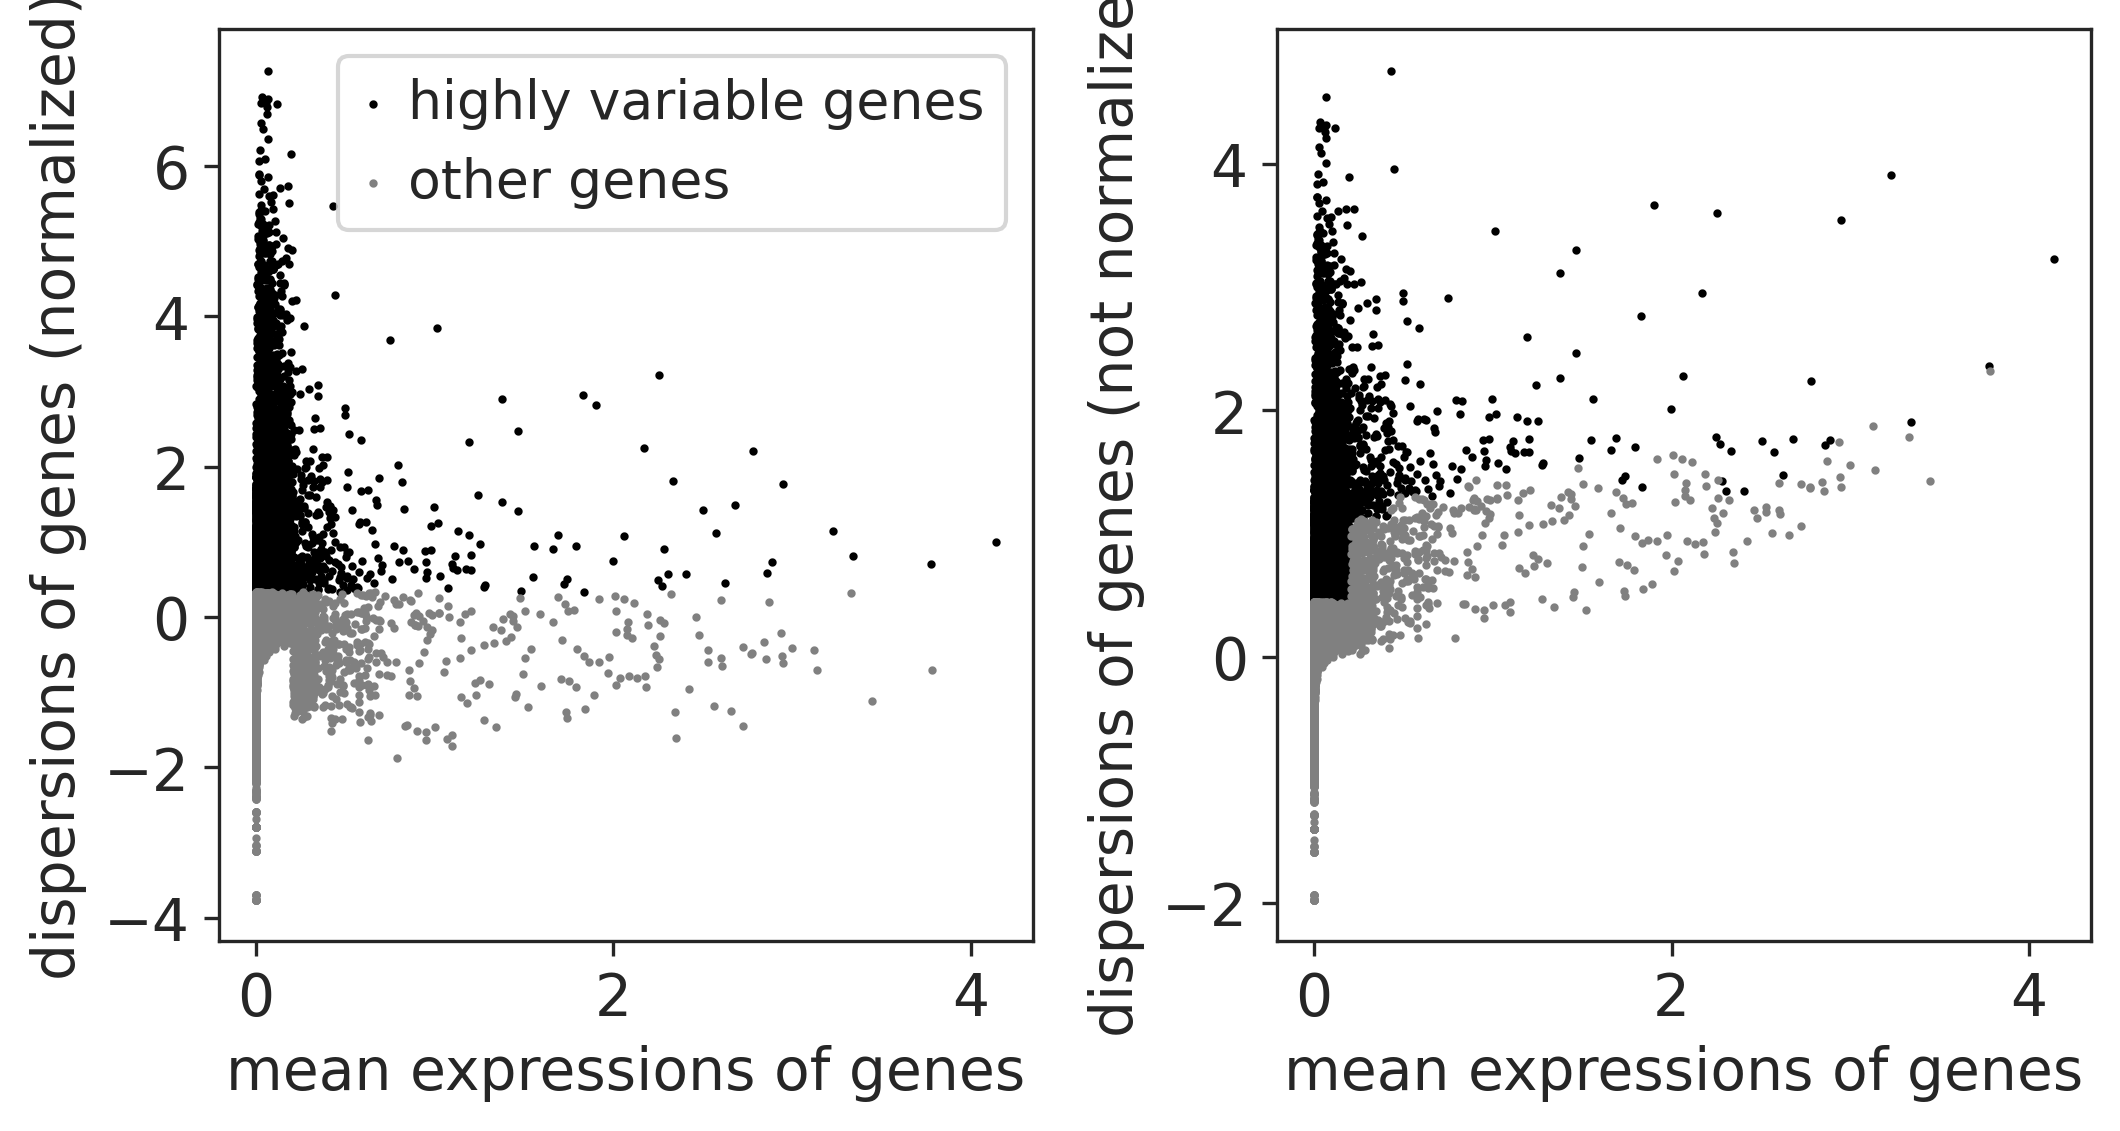

In [ ]:
sc.pp.highly_variable_genes(adata, n_top_genes=3000)
sc.pl.highly_variable_genes(adata)

In [ ]:
genes_1 = adata.var[adata.var.highly_variable].index

In [ ]:
sc.pp.highly_variable_genes(adata, n_top_genes=3000, flavor="seurat_v3", layer="counts")
# sc.pl.highly_variable_genes(adata, log=True)
     

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [ ]:
adata.layers["log1pPF"] = adata.X.copy()

In [ ]:
adata.raw = adata
sc.pp.scale(adata, max_value=10)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [ ]:
sc.tl.pca(adata, n_comps=50)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)


In [ ]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_rank', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'log1pPF'

# Функция для openTSNE
Еще немного подготовим данные, разделим имеющуюся таблицу на две, чтобы применить TSNE к одной и добавить другую. 

In [ ]:
import random
def random_adata(N, adata):
  sh = adata.shape
  rownum = sh[0]
  randomrow_f = random.sample(range(0, rownum), N)
  randomrow_s = list(set(range(0, rownum))^set(randomrow_f))
  adata_new_1 = adata[randomrow_f, :]
  adata_new_2 = adata[randomrow_s, :]
  return adata_new_1, adata_new_2

Посмотрим сколько у нас вообще клеток, чтобы понять, на какие части делить

In [ ]:
adata.shape

(2700, 32738)

In [ ]:
adata_1, adata_2 = random_adata(2000, adata)

Теперь применим openTSNE к исходной таблице, чтобы потом сравнить

In [ ]:
%%time
from openTSNE import TSNE

tsne = TSNE(perplexity=30, exaggeration=1, verbose=True)
adata.obsm["X_open_tsne"] = tsne.fit(adata.obsm["X_pca"][:, :15])

--------------------------------------------------------------------------------
TSNE(exaggeration=1, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 1.46 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.15 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.01 seconds
===> Running optimization with exaggeration=12.00, lr=225.00 for 250 iterations...
Iteration   50, KL divergence 3.4552, 50 iterations in 1.0569 sec
Iteration  100, KL divergence 3.2161, 50 iterations in 0.8771 sec
Iteration  150, KL divergence 3.1703, 50 iterations in 0.8756 sec
Iteration  200, KL divergence 3.1468, 50 iterations in 0.8802 sec
Iteration  250, KL divergence 3.1344, 50 iterations in 0.8859 sec
   --> Time elapsed: 4.58 seconds
===> Running optimization with exaggeration=1.00, lr=225.00 for 500 iterations..

Теперь сделаем саму функцию и применим ее к нашим таблицам

In [ ]:
from anndata import AnnData
from scipy import sparse
import anndata as ad
from openTSNE import TSNE
def transform_openTSNE(adata_1, adata_2):
  tsne = TSNE(perplexity=30, exaggeration=1, verbose=True)
  adata_1.obsm["X_open_tsne"] = tsne.fit(adata_1.obsm["X_pca"][:, :15])
  adata_2.obsm["X_open_tsne"] = adata_1.obsm["X_open_tsne"].transform(adata_2.obsm["X_pca"][:, :15])
  adata_new = ad.concat([adata_1, adata_2], join="inner")
  return adata_new, adata_1, adata_2

In [ ]:
adata_new, adata_new_1, adata_new_2 = transform_openTSNE(adata_1, adata_2)

--------------------------------------------------------------------------------
TSNE(exaggeration=1, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 1.08 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.11 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.01 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 3.1707, 50 iterations in 0.7756 sec
Iteration  100, KL divergence 2.9624, 50 iterations in 0.5928 sec
Iteration  150, KL divergence 2.9258, 50 iterations in 0.5924 sec
Iteration  200, KL divergence 2.9080, 50 iterations in 0.5982 sec
Iteration  250, KL divergence 2.8964, 50 iterations in 0.5976 sec
   --> Time elapsed: 3.16 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500 iterations..

Отрисуем то, что получилось для первого набора клеток, для добавленного набора клеток, при совмещении и то, что было изначально

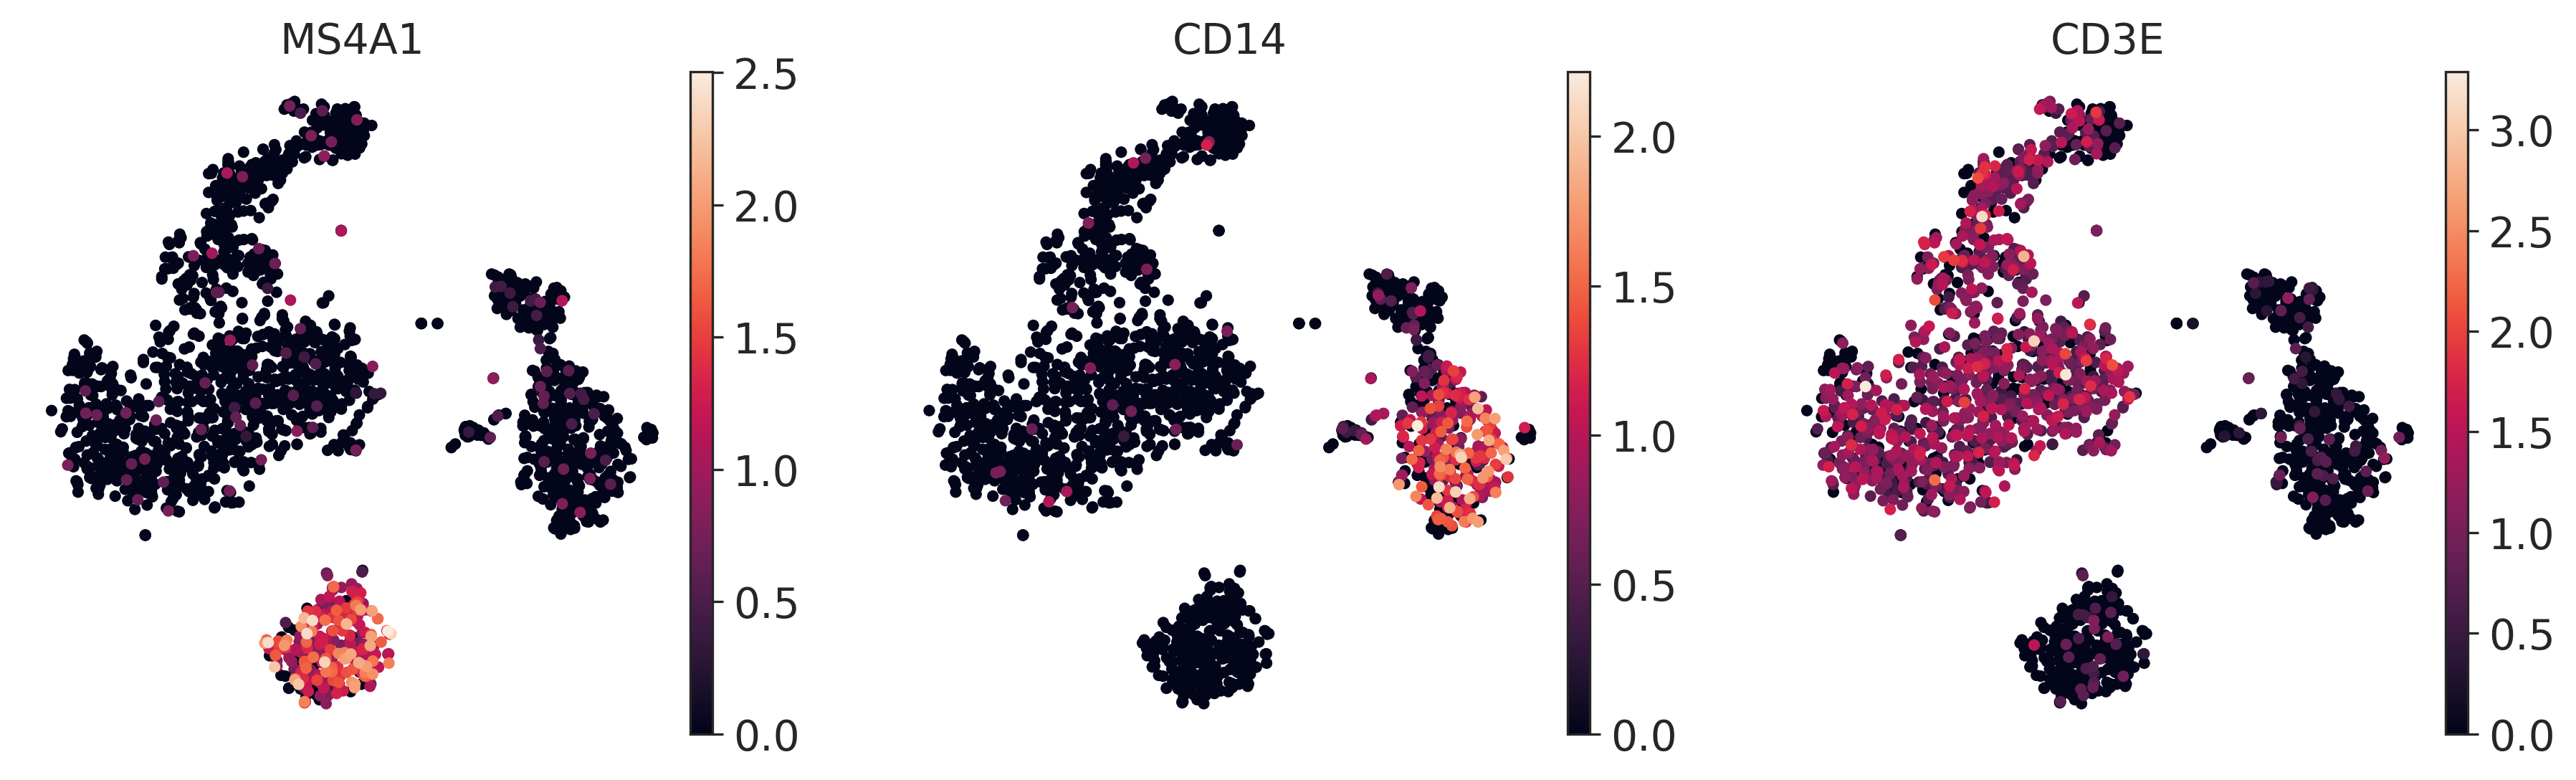

In [ ]:
sc.pl.embedding(adata_new_1, basis="X_open_tsne", color=["MS4A1", "CD14", "CD3E"], frameon=False)

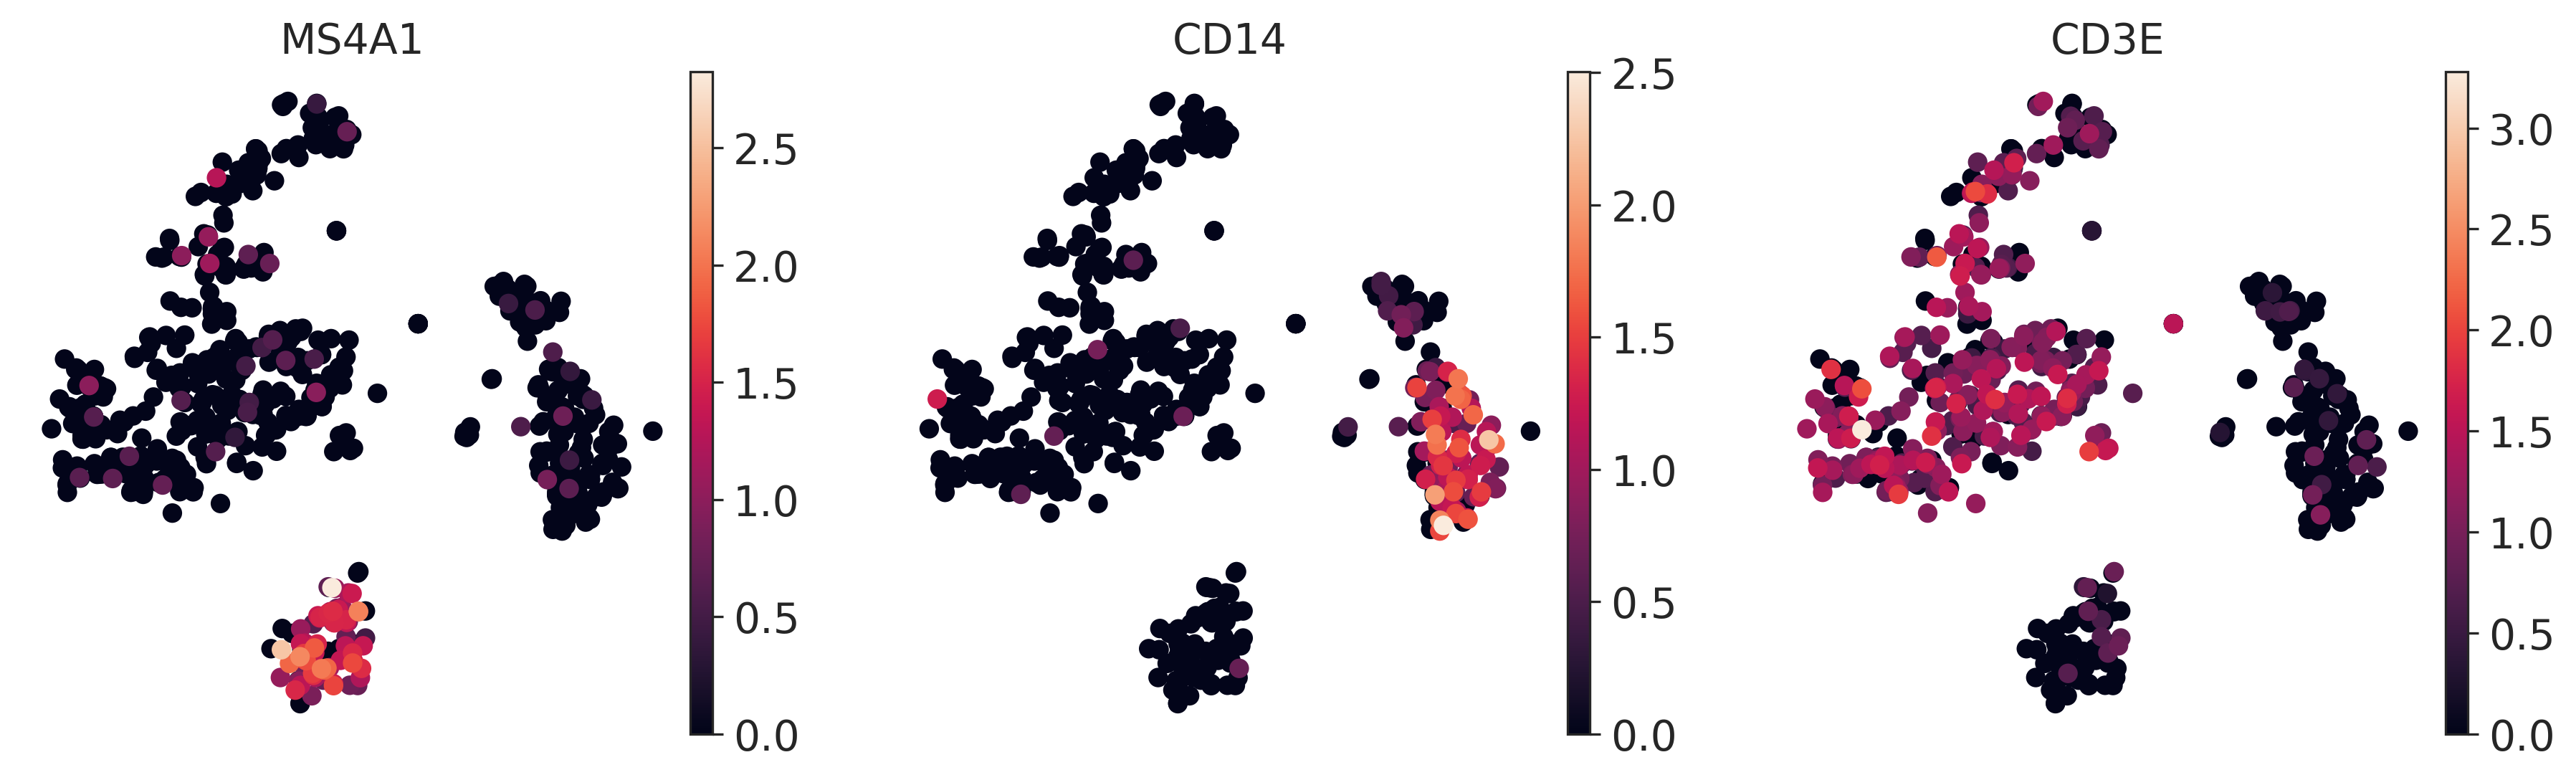

In [ ]:
sc.pl.embedding(adata_new_2, basis="X_open_tsne", color=["MS4A1", "CD14", "CD3E"], frameon=False)

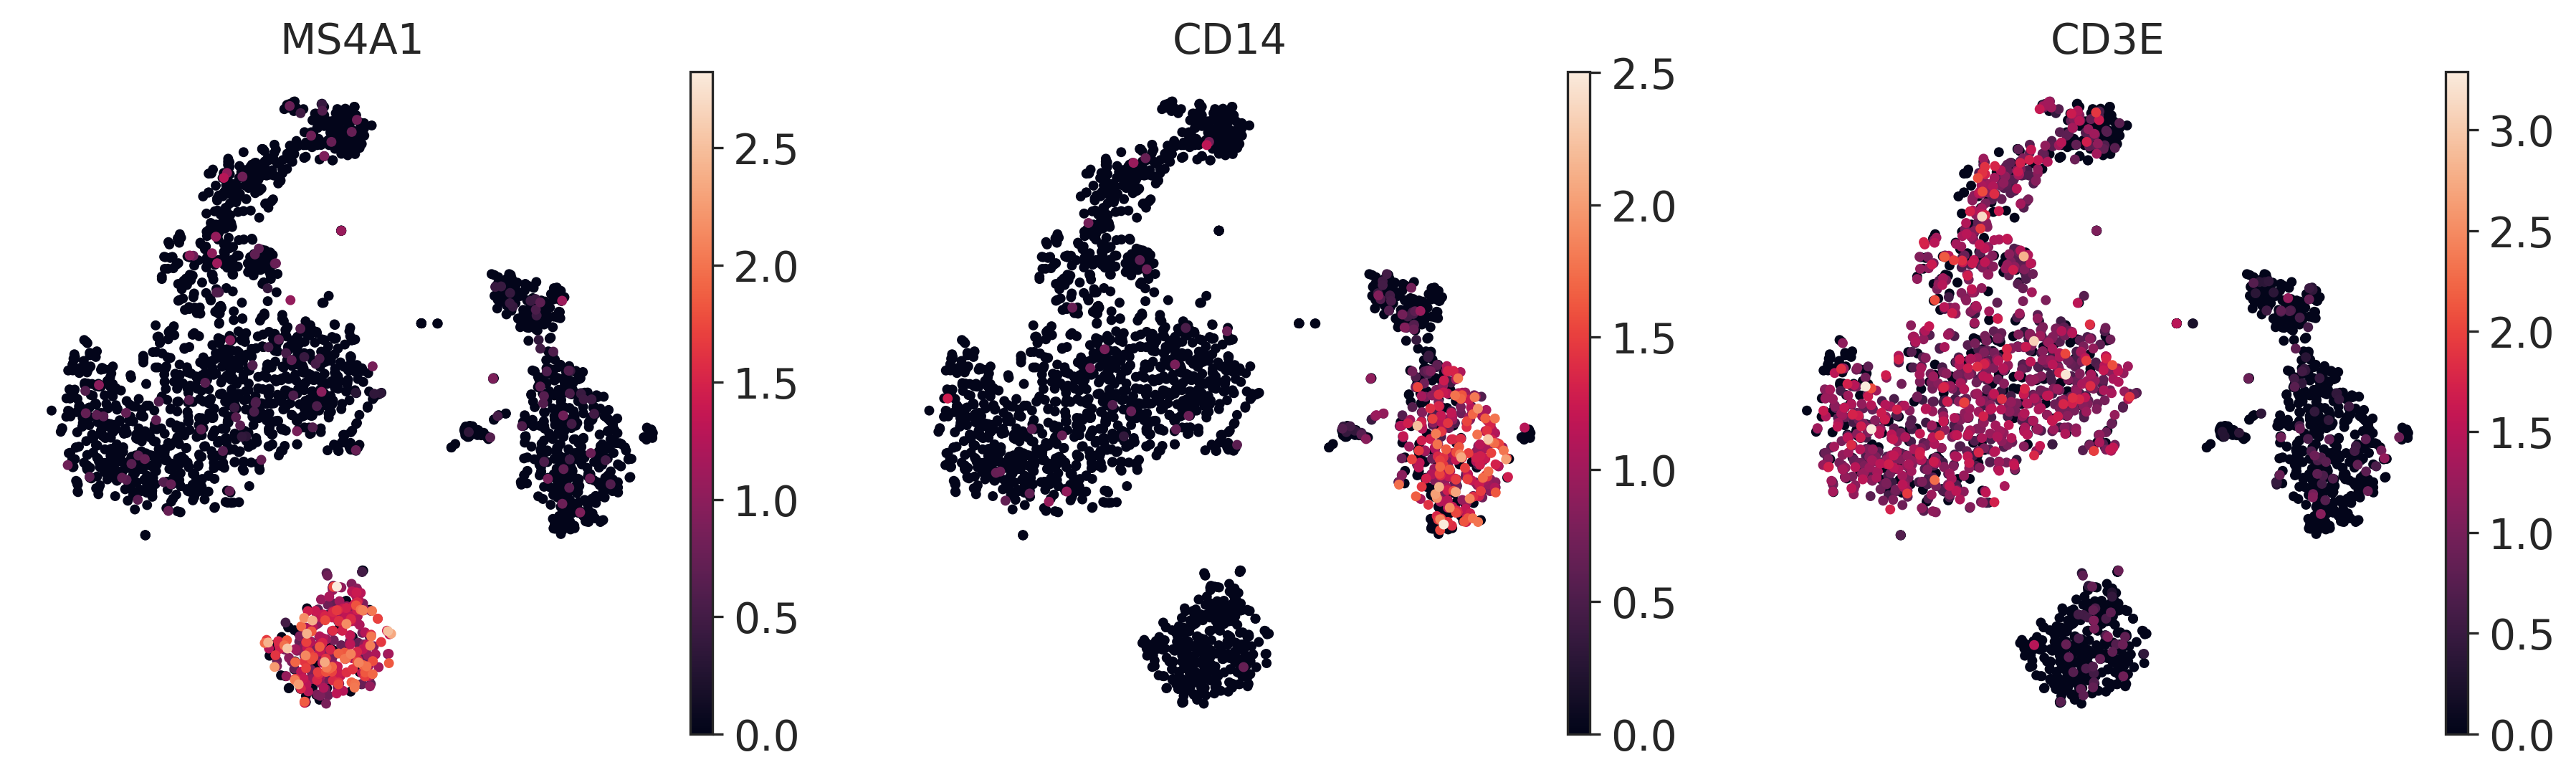

In [ ]:
sc.pl.embedding(adata_new, basis="X_open_tsne", color=["MS4A1", "CD14", "CD3E"], frameon=False)

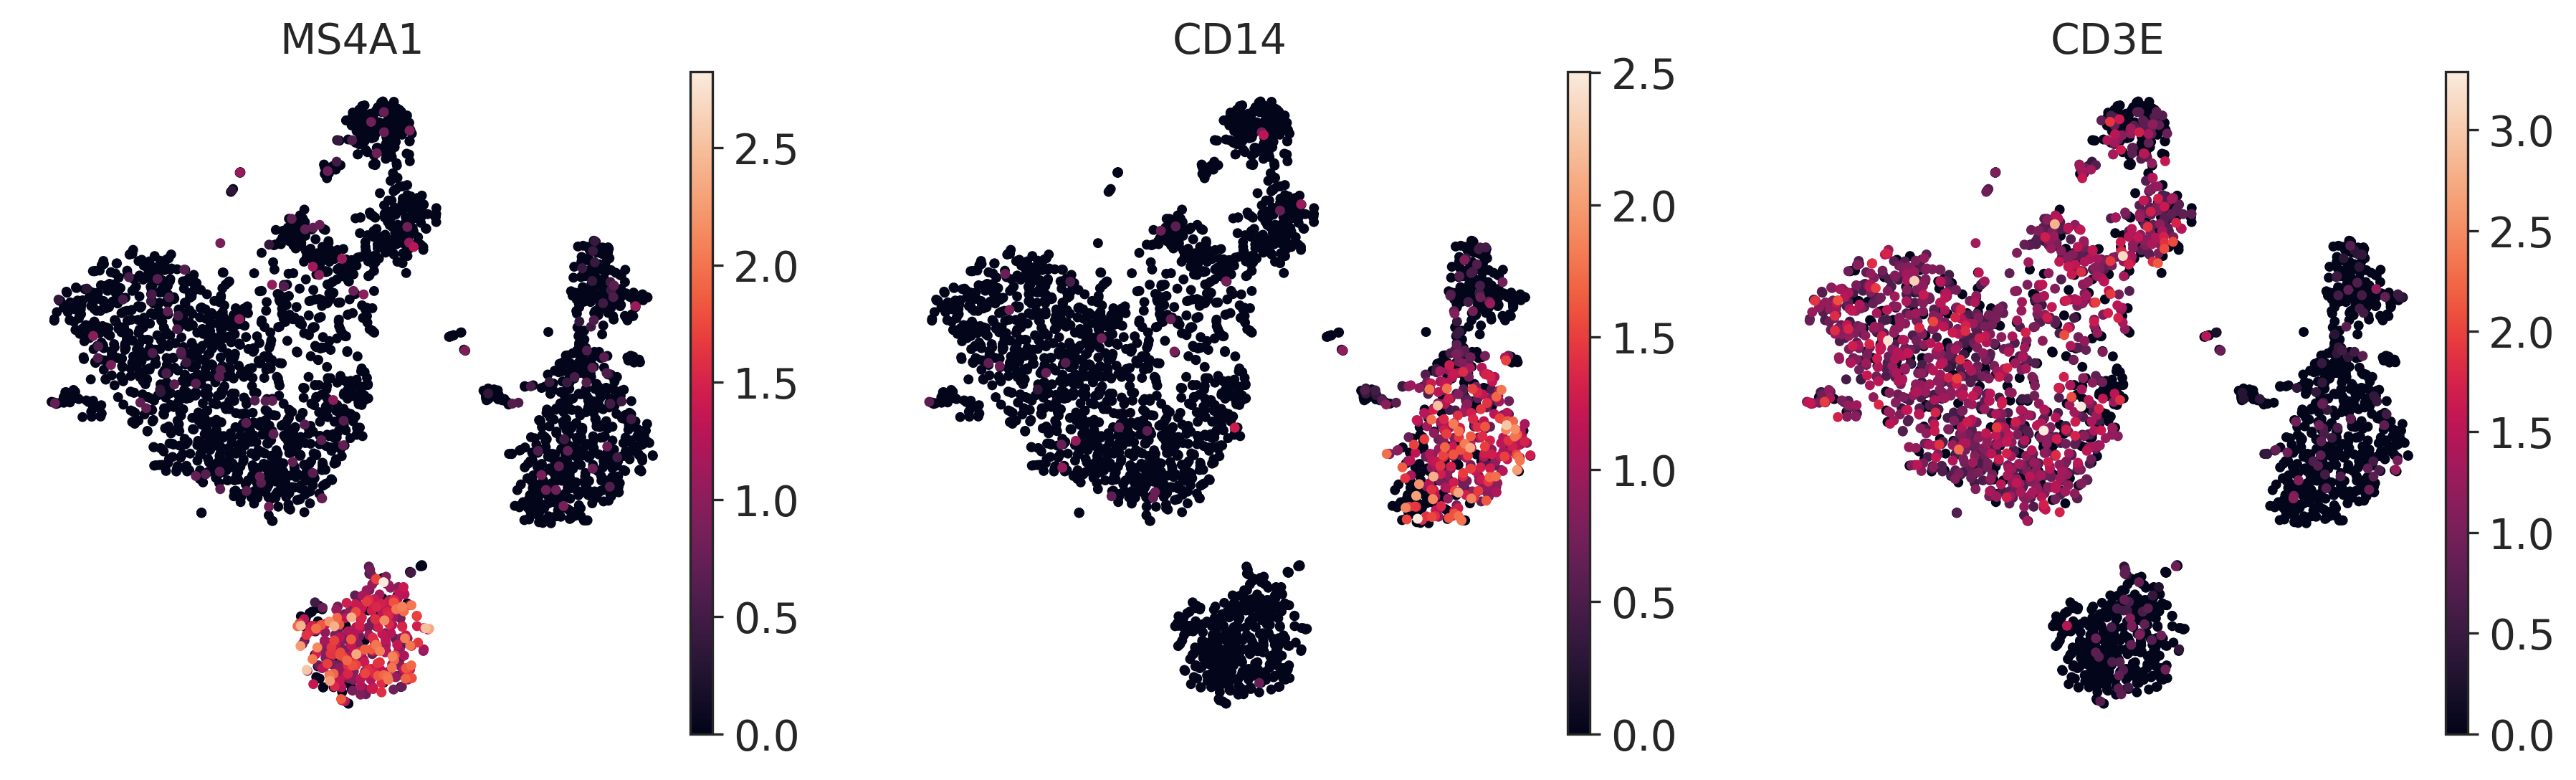

In [ ]:
sc.pl.embedding(adata, basis="X_open_tsne", color=["MS4A1", "CD14", "CD3E"], frameon=False)

Все неплохо получилось, ура